# Global metrics during GRACE era

In this notebook, our own model prediction performance is evaluated. This includes comparisons with GRACE, WaterGAP, and other reconstructions.

In [2]:
import string

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib_inline.backend_inline import set_matplotlib_formats
from sklearn.metrics import r2_score

import deepwaters  # noqa
from deepwaters import metrics
from deepwaters.regions import basins
from deepwaters.utils import ROOT_DIR
from deepwaters.visualization import plot_basinwise_map


In [3]:
# Register dask progress bar
ProgressBar(minimum=5).register()


In [4]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "docs/figures/paper"


## Data Preprocessing

### Data Loading

Load and combine the different data sets (GRACE, ERA5, WGHM, and our and other reconstructions)

In [5]:
# Zarr store paths
stores = [
    ROOT_DIR / "data/processed/targets.zarr",
    ROOT_DIR / "data/processed/inputs.zarr",
    ROOT_DIR / "data/processed/reconstructions.zarr",
    ROOT_DIR / "models/predictions/global/ensemble_alltrain_10folds_combined.zarr",
]
ds_all = xr.merge([xr.open_zarr(store) for store in stores])

ds_all


<xarray.Dataset> Size: 69GB
Dimensions:                                    (lat: 360, lon: 720, time: 1480)
Coordinates:
  * lat                                        (lat) float64 3kB -89.75 ... 8...
  * lon                                        (lon) float64 6kB -179.8 ... 1...
  * time                                       (time) datetime64[ns] 12kB 190...
Data variables: (12/59)
    land_mask_gsfc                             (lat, lon) float32 1MB dask.array<chunksize=(360, 720), meta=np.ndarray>
    land_mask_jpl                              (lat, lon) float32 1MB dask.array<chunksize=(360, 720), meta=np.ndarray>
    twsa_csr                                   (time, lat, lon) float32 2GB dask.array<chunksize=(210, 360, 180), meta=np.ndarray>
    twsa_gsfc                                  (time, lat, lon) float32 2GB dask.array<chunksize=(210, 360, 180), meta=np.ndarray>
    twsa_jpl                                   (time, lat, lon) float32 2GB dask.array<chunksize=(210, 360, 180), meta=np.ndarray>
    cell_area                                  (lat, lon) float32 1MB dask.array<chunksize=(360, 720), meta=np.ndarray>
    ...                                         ...
    yin_jpl_full                               (time, lat, lon) float32 2GB dask.array<chunksize=(996, 120, 120), meta=np.ndarray>
    yin_jpl_zerofill                           (time, lat, lon) float32 2GB dask.array<chunksize=(996, 120, 120), meta=np.ndarray>
    pred_ensemble_alltrain_gap_lnll_latest     (time, lat, lon) float32 2GB dask.array<chunksize=(973, 120, 120), meta=np.ndarray>
    pred_ensemble_alltrain_nogap_lnll_latest   (time, lat, lon) float32 2GB dask.array<chunksize=(973, 120, 120), meta=np.ndarray>
    sigma_ensemble_alltrain_gap_lnll_latest    (time, lat, lon) float32 2GB dask.array<chunksize=(973, 120, 120), meta=np.ndarray>
    sigma_ensemble_alltrain_nogap_lnll_latest  (time, lat, lon) float32 2GB dask.array<chunksize=(973, 120, 120), meta=np.ndarray>
Attributes: (12/53)
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    C_20_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    GIA_removed:                   ICE6G-D; Peltier, W. R., D. F. Argus, and ...
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    ...                            ...
    time_coverage_start:           2002-04-16T00:00:00Z
    time_epoch:                    2002-01-01T00:00:00Z
    time_mean_removed:             2004.000 to 2009.999
    title:                         JPL GRACE and GRACE-FO MASCON RL06.1Mv03 CRI
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...

Specify variables of interest and their descriptive names:

In [6]:
# shorten name of our reconstruction
ds_all = ds_all.rename(pred_ensemble_alltrain_nogap_lnll_latest="twsa_our")


In [7]:
target_var = "twsa_csr"
our_var = "twsa_our"


In [8]:
# Create and apply land mask
mask = (ds_all.land_mask_jpl * ds_all.land_mask_gsfc * ds_all.grl_ata_mask).compute()
ds_all = ds_all.where(mask == 1)


In [9]:
# Substract the GRACE baseline
baseline = slice("2004", "2009")
base_mean = ds_all.sel(time=baseline).mean("time")
ds_all = ds_all - base_mean


## Error and correlation world maps

In [10]:
ds_grid = ds_all[[target_var, our_var]]
# Only evaluate GRACE time
ds_grid = ds_grid.sel(time=slice("2002-04", "2021-12")).compute()
# Calculate grid averages
ds_basin = (
    # Select variables and time frame of interest
    ds_grid.chunk(time=10, lat=-1, lon=-1)
    .dw.select_basins(top=72)
    .dw.weight_lat()
    .mean(["lat", "lon"])
    .compute()
)


[########################################] | 100% Completed | 63.79 s


In [11]:
# RMSE
our_rmse_grid = metrics.rmse(
    ds_grid[target_var], ds_grid[our_var], dim="time", skipna=True
)
our_rmse_basin = metrics.rmse(
    ds_basin[target_var], ds_basin[our_var], dim="time", skipna=True
)

# NSE
our_nse_grid = metrics.nse(
    ds_grid[target_var], ds_grid[our_var], dim="time", skipna=True
)
our_nse_basin = metrics.nse(
    ds_basin[target_var], ds_basin[our_var], dim="time", skipna=True
)


c:\Users\luisg\Repositories\deepwaters\.venv\Lib\site-packages\xarray\core\nputils.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [12]:
rmse_kwargs = dict(
    cbar_kwargs=dict(
        location="right", aspect=15, shrink=0.93, pad=0.03, label="RMSE (mm)"
    ),
    cmap="viridis",
    zorder=2,
    rasterized=True,
)
nse_kwargs = dict(
    cbar_kwargs=dict(location="right", aspect=15, shrink=0.93, pad=0.03, label="NSE"),
    cmap="magma",
    zorder=2,
    rasterized=True,
)
basinlines_kwargs = dict(
    edgecolor="black",
    linewidth=0.5,
    facecolor="None",
    zorder=3,
    rasterized=True,
)
title_kwargs = dict(fontsize=16, weight="bold")


In [13]:
basin_shapes = basins(top=72)

In [14]:
print(f"{our_rmse_grid.min() = :.2f}")
print(f"{our_rmse_grid.max() = :.2f}")

print(f"{our_nse_grid.min() = :.2f}")
print(f"{our_nse_grid.max() = :.2f}")

print(f"{our_rmse_basin.min() = :.2f}")
print(f"{our_rmse_basin.max() = :.2f}")

print(f"{our_nse_basin.min() = :.2f}")
print(f"{our_nse_basin.max() = :.2f}")


our_rmse_grid.min() = 4.59
our_rmse_grid.max() = 3326.54
our_nse_grid.min() = -231.36
our_nse_grid.max() = 1.00
our_rmse_basin.min() = 3.72
our_rmse_basin.max() = 21.06
our_nse_basin.min() = 0.90
our_nse_basin.max() = 1.00


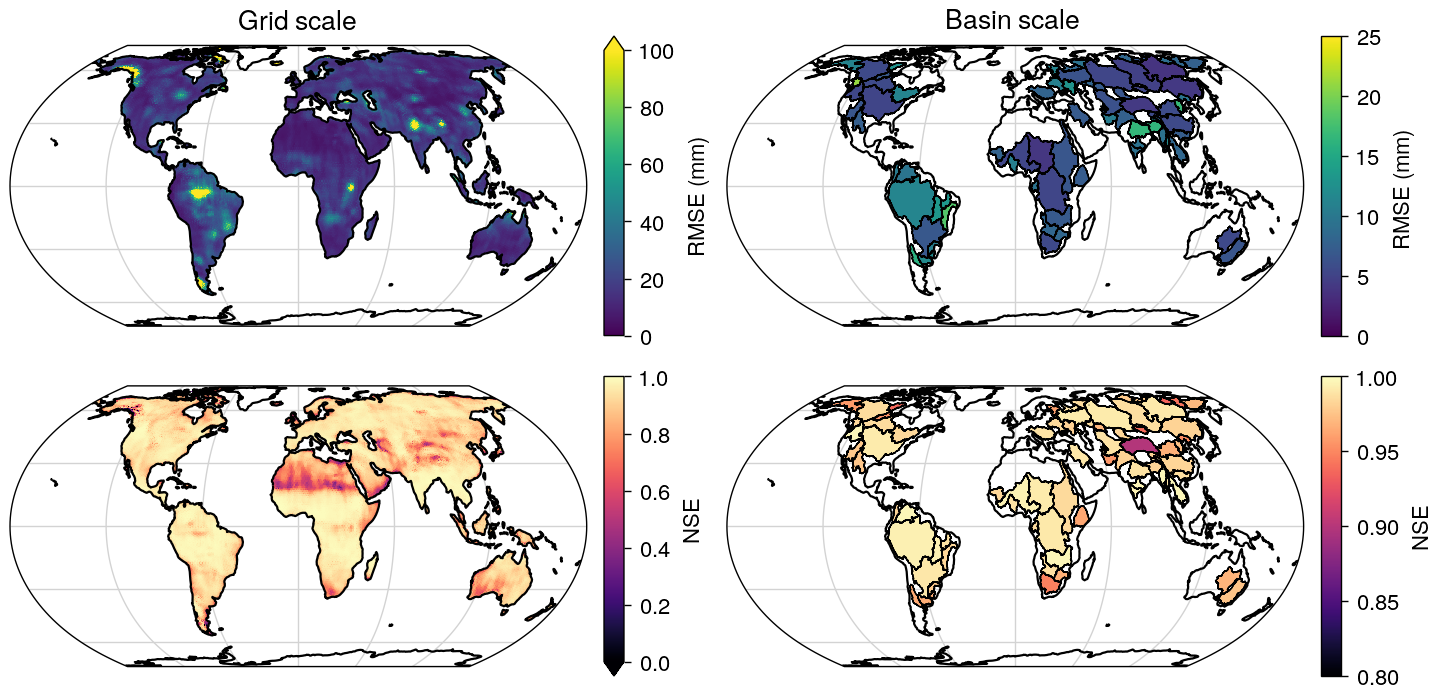

In [15]:
fig, axs = plt.subplots(
    2, 2, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(7.2, 3.5)
)

# Add gridlines
for ax in axs.flat:
    ax.gridlines(zorder=1)

# Grid scale plots
our_rmse_grid.dw.projplot(vmin=0, vmax=100, ax=axs[0][0], **rmse_kwargs)
our_nse_grid.dw.projplot(vmin=0.0, vmax=1.0, ax=axs[1][0], **nse_kwargs)

# Basin scale plots
plot_basinwise_map(
    our_rmse_basin,
    our_rmse_grid,
    vmin=0,
    vmax=25,
    ax=axs[0][1],
    **rmse_kwargs,
)
plot_basinwise_map(
    our_nse_basin,
    our_nse_grid,
    vmin=0.8,
    vmax=1.0,
    ax=axs[1][1],
    **nse_kwargs,
)

# Add basinlines
for ax in [axs[0][1], axs[1][1]]:
    basin_shapes.dw.projplot(ax=ax, **basinlines_kwargs)

# Add coastlines
for ax in axs.flat:
    ax.coastlines(rasterized=True, zorder=4)

# Titles
axs[0][0].set(title="Grid scale")
axs[0][1].set(title="Basin scale")

fig.savefig(FIGURE_DIR / "grace_comp_map.pdf", backend="pgf")


## Scatter plots of signal components

### Perform linear trend / multi-seasonal decomposition

We use the following function to approximate the constant $a$, the linear trend $b$, and the annual and semi-annual sinusoidal curves:

$$
y(t) = a + b \, t + c \, \sin(2π  \, t) + d \, \cos(2π \, t) + e \, \sin(4π \, t) + f \cos(4π \, t) + r
$$

In [16]:
YEAR_NS = 365.25 * 24 * 60 * 60 * 1e9


def decomp_func(
    t: np.ndarray, a: float, b: float, c: float, d: float, e: float, f: float
) -> np.ndarray:
    # Convert t from nanosecons to years
    t = t / YEAR_NS

    linear = a + b * t
    annual = c * np.sin(2 * np.pi * t) + d * np.cos(2 * np.pi * t)
    semian = e * np.sin(4 * np.pi * t) + f * np.cos(4 * np.pi * t)

    return linear + annual + semian


In [17]:
# Apply decomposition
# Curvefit skips missing values per default
fit = ds_basin.to_dataarray("model").curvefit("time", decomp_func)
fit


<xarray.Dataset> Size: 49kB
Dimensions:                (region: 72, model: 2, param: 6, cov_i: 6, cov_j: 6)
Coordinates:
  * region                 (region) object 576B 'Congo' 'Niger' ... 'Volga'
  * model                  (model) object 16B 'twsa_csr' 'twsa_our'
  * param                  (param) <U1 24B 'a' 'b' 'c' 'd' 'e' 'f'
  * cov_i                  (cov_i) <U1 24B 'a' 'b' 'c' 'd' 'e' 'f'
  * cov_j                  (cov_j) <U1 24B 'a' 'b' 'c' 'd' 'e' 'f'
Data variables:
    curvefit_coefficients  (model, region, param) float64 7kB -148.8 ... -3.53
    curvefit_covariance    (model, region, cov_i, cov_j) float64 41kB 318.8 ....

### Calculate slope and amplitudes

In [18]:
# Linear trend: mm / yr
da_lintrend = fit.curvefit_coefficients.sel(param="b")

da_lintrend.attrs = {"long_name": "Trend", "unit": "mm / yr"}


Calculate annual amplitude:

$$
A = \sqrt{c^2 + d^2}
$$

In [19]:
c = fit.curvefit_coefficients.sel(param="c")
d = fit.curvefit_coefficients.sel(param="d")
e = fit.curvefit_coefficients.sel(param="e")
f = fit.curvefit_coefficients.sel(param="f")

da_amp_annual = np.sqrt(c**2 + d**2)
da_amp_semian = np.sqrt(e**2 + f**2)

da_amp_annual.attrs = {"long_name": "Annual amplitude", "unit": "mm"}
da_amp_semian.attrs = {"long_name": "Semi-annual amplitude", "unit": "mm"}


In [20]:
# Dataframe containing basin sizes
basin_sizes = basin_shapes[["river", "sum_sub_ar"]].rename(
    columns={"river": "region", "sum_sub_ar": "area"}
)
# km² to M km³
basin_sizes.area /= 1e6


In [21]:
# Place components in dictionaries for easier batch handling
da_comps = {
    "lintrend": da_lintrend,
    "amp_annual": da_amp_annual,
    "amp_semian": da_amp_semian,
}
df_comps = {}
r2_scores = {}

for name, da in da_comps.items():
    # Convert DataArrays to DataFrames for plotting with Seaborn
    df = (
        da.to_pandas()
        .transpose()
        .reset_index()
        # Add basin size column
        .merge(basin_sizes, on="region")
        # Sort after area so large basins are printed lastly
        .sort_values("area")
    )
    df_comps[name] = df

    # Calculate R2 score
    r2_scores[name] = r2_score(df[target_var], df[our_var], sample_weight=df["area"])


In [22]:
# Units
units = {
    "lintrend": "mm",
    "amp_annual": "mm yr$^-1$",
    "amp_semian": "mm yr$^-1$",
}
# Verbose names
names_verbose = {
    "lintrend": "Linear\ntrend",
    "amp_annual": "Annual\namplitude",
    "amp_semian": "Semiannual\namplitude",
}


In [23]:
print(f"{da_lintrend.min() = :.2f}")
print(f"{da_lintrend.max() = :.2f}")

print(f"{da_amp_annual.min() = :.2f}")
print(f"{da_amp_annual.max() = :.2f}")

print(f"{da_amp_semian.min() = :.2f}")
print(f"{da_amp_semian.max() = :.2f}")


da_lintrend.min() = -16.86
da_lintrend.max() = 10.96
da_amp_annual.min() = 5.34
da_amp_annual.max() = 217.75
da_amp_semian.min() = 0.32
da_amp_semian.max() = 64.87


In [24]:
# Limits
lims = {
    "lintrend": (-20, 10),
    "amp_annual": (0, 250),
    "amp_semian": (0, 80),
}


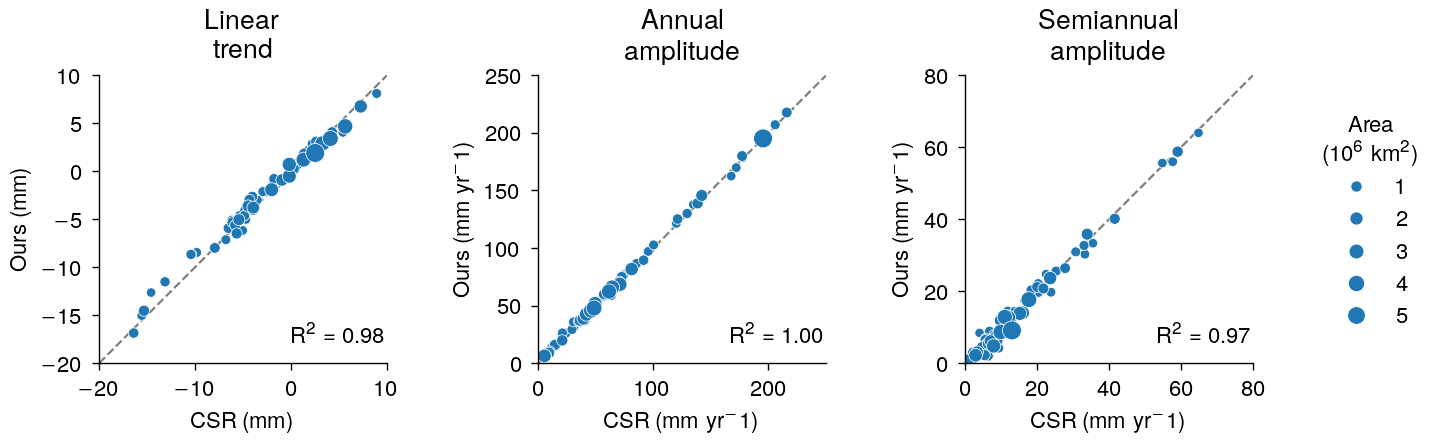

In [25]:
fig, axs = plt.subplots(ncols=3, subplot_kw={"aspect": 1}, figsize=(7.2, 2.2))

for i, (ax, (name, df)) in enumerate(zip(axs, df_comps.items())):
    sns.scatterplot(
        df,
        x=target_var,
        y=our_var,
        ax=ax,
        size="area",
        legend=True if i == 0 else False,
    )

    # Unpack dicts
    name_verbose = names_verbose[name]
    unit = units[name]
    lim = lims[name]
    r2 = r2_scores[name]

    ax.set(
        title=name_verbose,
        xlabel=f"CSR ({unit})",
        ylabel=f"Ours ({unit})",
        xlim=lim,
        ylim=lim,
    )

    # Add diagonal line
    ax.plot(
        lim,
        lim,
        color="gray",
        linestyle="dashed",
        linewidth=0.8,
        zorder=0,
    )

    # Add R2 score
    ax.text(1.0, 0.07, f"R$^2$ = {r2 :.2f}", ha="right", transform=ax.transAxes)


# Place legend outside of axes
axs[0].legend().remove()
legend = fig.legend(loc="outside right", title="Area\n($10^6$ km$^2$)")
legend.get_title().set_ha("center")

fig.savefig(FIGURE_DIR / "grace_comp_scatter.pdf", backend="pgf")


## Combine Everything

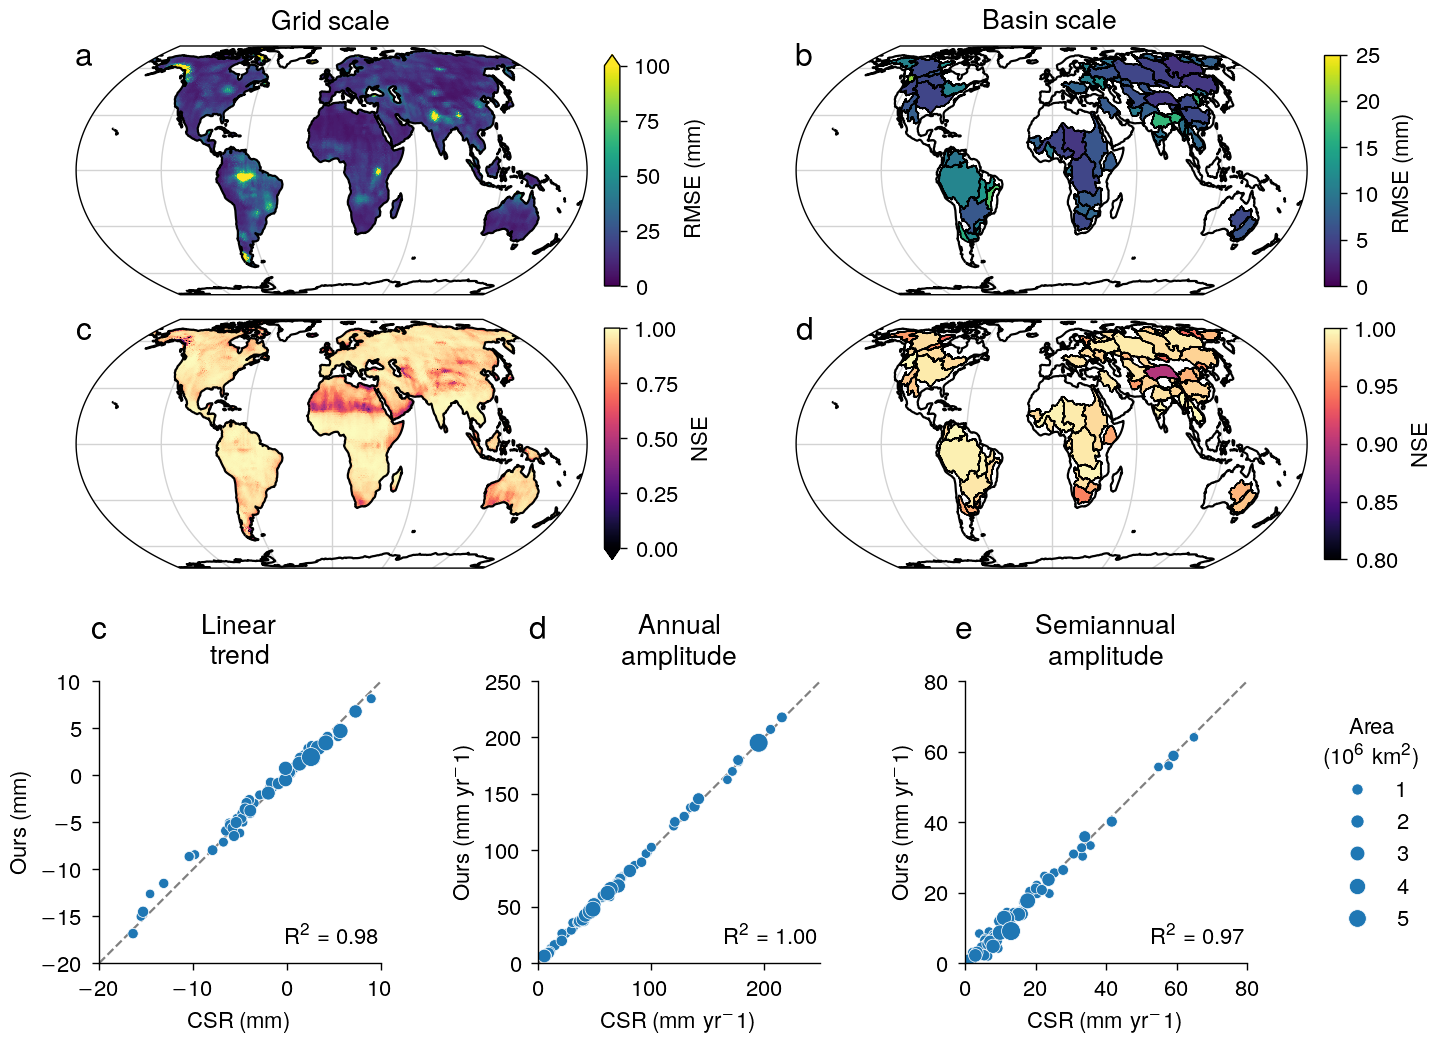

In [26]:
fig = plt.figure(figsize=(7.2, 5.2))
subfigs = fig.subfigures(nrows=2, hspace=0.05, height_ratios=[4, 3])

axs_geo = subfigs[0].subplots(2, 2, subplot_kw={"projection": ccrs.EqualEarth()})
axs_scatter = subfigs[1].subplots(1, 3, subplot_kw={"aspect": 1})

axs_rmse, axs_nse = axs_geo

### MAP PLOTS ###

# Add gridlines
for ax in axs_geo.flat:
    ax.gridlines(zorder=1)

# Grid scale plots
our_rmse_grid.dw.projplot(vmin=0, vmax=100, ax=axs_rmse[0], **rmse_kwargs)
our_nse_grid.dw.projplot(vmin=0.0, vmax=1.0, ax=axs_nse[0], **nse_kwargs)

# Basin scale plots
plot_basinwise_map(
    our_rmse_basin,
    our_rmse_grid,
    vmin=0,
    vmax=25,
    ax=axs_rmse[1],
    **rmse_kwargs,
)
plot_basinwise_map(
    our_nse_basin,
    our_nse_grid,
    vmin=0.8,
    vmax=1.0,
    ax=axs_nse[1],
    **nse_kwargs,
)

# Add basinlines
for ax in [axs_rmse[1], axs_nse[1]]:
    basin_shapes.dw.projplot(ax=ax, **basinlines_kwargs)

# Add coastlines
for ax in axs_geo.flat:
    ax.coastlines(rasterized=True, zorder=4)

# Titles
axs_rmse[0].set(title="Grid scale")
axs_rmse[1].set(title="Basin scale")


### SCATTER PLOT ###

for i, (ax, (name, df)) in enumerate(zip(axs_scatter, df_comps.items())):
    sns.scatterplot(
        df,
        x=target_var,
        y=our_var,
        ax=ax,
        size="area",
        legend=True if i == 0 else False,
    )

    # Unpack dicts
    name_verbose = names_verbose[name]
    unit = units[name]
    lim = lims[name]
    r2 = r2_scores[name]

    ax.set(
        title=name_verbose,
        xlabel=f"CSR ({unit})",
        ylabel=f"Ours ({unit})",
        xlim=lim,
        ylim=lim,
    )

    # Add diagonal line
    ax.plot(
        lim,
        lim,
        color="gray",
        linestyle="dashed",
        linewidth=0.8,
        zorder=0,
    )

    # Add R2 score
    ax.text(1.0, 0.07, f"R$^2$ = {r2 :.2f}", ha="right", transform=ax.transAxes)


# Place legend outside of axes
axs_scatter[0].legend().remove()
legend = subfigs[1].legend(loc="outside right", title="Area\n($10^6$ km$^2$)")
legend.get_title().set_ha("center")

# Add letters
for n, ax in enumerate(axs_geo.flat):
    ax.text(
        0.0,
        1.0 - 0.08,
        string.ascii_lowercase[n],
        transform=ax.transAxes,
        size="x-large",
        weight="bold",
    )
for n, ax in enumerate(axs_scatter):
    ax.text(
        0.0,
        1.0 + 0.15,
        string.ascii_lowercase[n + len(axs_geo)],
        ha="center",
        transform=ax.transAxes,
        size="x-large",
        weight="bold",
    )

fig.savefig(FIGURE_DIR / "grace_comp.pdf", backend="pgf")
